# Creating new model from scratch

The real power of `MultiModel` framework is in fast prototyping of heterogeneous models. To showcase this, in this notebook we create a brand new model in the framework (the famous Jansen-Rit model), and then create a thalamocortical mini network with 1 node representing a thalamus and 1 node Jansen-Rit model representing a cortical column.

## Jansen-Rit model
The Jansen-Rit model is a neural population model of a local cortical circuit. It contains three interconnected neural populations: one for the pyramidal projection neurons and two for excitatory and inhibitory interneurons forming feedback loops.

The equations for Jansen-Rit model reads:
\begin{align}
\ddot{x}_{0} & = Aa\cdot\mathrm{Sigm}\left(x_{1} - x_{2}\right) - 2a\dot{x}_{0} - a^{2}x_{0} \\
\ddot{x}_{1} & = Aa[p + C_{2}\mathrm{Sigm}\left(C_{1}x_{0}\right)] - 2a\dot{x}_{1} - a^2x_{1} \\
\ddot{x}_{2} & = BbC_{4}\mathrm{Sigm}\left( C_{3}x_{o} \right) - 2b\dot{x}_{2} - b^2x_{2} \\
\mathrm{Sigm}(x) & = \frac{v_{max}}{1 + \mathrm{e}^{r(v_{0} - x)}}
\end{align}
Of course, in order to implement the above equations numerically, the system of three second-order ODEs will be rewritten into a system of six first-order ODEs.

## `MultiModel` strategy
The actual implementation will be a bit more involved than simply writing down the above equations. The building block of any proper `MultiModel` is a `NeuralMass`. Jansen-Rit model actually summarises an activity of a cortical column consisting of three populations: a population of pyramidal cells interacting with two populations of interneurons - one excitatory and one inhibitory. Moreover, the $x$ represent the average membrane potential, but typically, neuronal models (at least in `neurolib`) are coupled via firing rate. For this reason, our main output variable would actually be a firing rate of a main, pyramidal population. The average membrane potential of a pyramidal population is $x = x_{1} - x_{2}$ and its firing rate is then $r = \mathrm{Sigm}(x) = \mathrm{Sigm}(x_{1} - x_{2})$. Similar strategy (sigmoidal transfer function for average membrane potential) is used for the thalamic model.

The coupling variable in `MultiModel` must be the same across all hierarchical levels. Individial populations in Jansen-Rit model are coupled via their average membrane potentials $x_{i}$, $i\in[0, 1, 2]$. However, the "global" coupling variable for the node would be the firing rate of pyramidal population $r$, introduced in the paragraph above. To reconcile this, two options exists in `MultiModel`:
* create a `NeuralMass` representing a pyramidal population with two coupling variables: $x_{0}$ and $r$; `NeuralMass` representing interneurons would have one coupling variable, $x_{1,2}$
    * advantages: cleaner (implementation), more modular (can create J-R `Node` with more masses than 3 very easily)
    * disadvantages: more code, might be harder to navigate for the beginner
* create one `NeuralMass` representing all three populations with one coupling variable $r$, since the others are not really coupling since the whole dynamics is contained in one object
    * advantages: less code, easier to grasp
    * disadvantages: less modular, cannot simply edit J-R model, since everything is "hardcoded" into one `NeuralMass` object

In order to build a basic understanding of building blocks, we will follow the second option here (less code, easier to grasp). For interested readers, the first option (modular one) will be implemented in `MultiModel`, so you can follow the model files.

Our strategy for this notebook then would be:
1. implement single `NeuralMass` object representing all three populations in the Jansen-Rit model, with single coupling variable $r$
2. implement a "dummy" `Node` with single `NeuralMass` (requirement, one cannot couple `Node` to a `NeuralMass` to build a network)
3. experiment with connecting this Jansen-Rit cortical model to the thalamic population model

Last note, all model's dynamics and parameters in `MultiModel` are defined in milliseconds, therefore we will scale the default parameters.

Let us start with the imports:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import symengine as se
from IPython.display import display
from jitcdde import input as system_input
from neurolib.models.multimodel import MultiModel, ThalamicNode
from neurolib.models.multimodel.builder.base.constants import LAMBDA_SPEED
from neurolib.models.multimodel.builder.base.network import Network, Node
from neurolib.models.multimodel.builder.base.neural_mass import NeuralMass
from neurolib.utils.functions import getPowerSpectrum
from neurolib.utils.stimulus import Input, OrnsteinUhlenbeckProcess, StepInput

A quick detour before we dive into the model itself. Jansen-Rit model is typically driven with a uniformly distributed noise, as the authors wanted to model nonspecific input (they used the term *background spontaneous activity*). For this we quickly create our model input using the `ModelInput` class (the tutorial on how to use stimuli in `neurolib` is given elsewhere).

In [2]:
class UniformlyDistributedNoise(Input):
    """
    Uniformly distributed noise process between two values.
    """

    def __init__(self, low, high, n=1, seed=None):
        # save arguments as attributes for later
        self.low = low
        self.high = high
        # init super
        super().__init__(n=n, seed=seed)

    def generate_input(self, duration, dt):
        # generate time vector
        self._get_times(duration=duration, dt=dt)
        # generate noise process itself with the correct shape
        # as (time steps x num. processes)
        return np.random.uniform(
            self.low, self.high, (self.n, self.times.shape[0])
        )

In [3]:
# let us build a proper hierarchy, i.e. we firstly build a Jansen-Rit mass
class SingleJansenRitMass(NeuralMass):
    """
    Single Jansen-Rit mass implementing whole three population dynamics.

    Reference:
        Jansen, B. H., & Rit, V. G. (1995). Electroencephalogram and visual evoked potential
        generation in a mathematical model of coupled cortical columns. Biological cybernetics,
        73(4), 357-366.
    """

    # all these attributes are compulsory to fill in
    name = "Jansen-Rit mass"
    label = "JRmass"

    num_state_variables = 7  # 6 ODEs + firing rate coupling variable
    num_noise_variables = 1  # single external input
    # NOTE 
    # external inputs (so-called noise_variables) are typically background noise drive in models,
    # however, this can be any type of stimulus - periodic stimulus, step stimulus, square pulse,
    # anything. Therefore you may want to add more stimuli, e.g. for Jansen-Rit model three to each
    # of its population. Here we do not stimulate our Jansen-Rit model, so only use actual noise
    # drive to excitatory interneuron population.
    # as dictionary {index of state var: it's name}
    coupling_variables = {6: "r_mean_EXC"}
    # as list
    state_variable_names = [
        "v_pyr",
        "dv_pyr",
        "v_exc",
        "dv_exc",
        "v_inh",
        "dv_inh",
        # to comply with other `MultiModel` nodes
        "r_mean_EXC",
    ]
    # as list
    # note on parameters C1 - C4 - all papers use one C and C1-C4 are
    # defined as various rations of C, typically: C1 = C, C2 = 0.8*C
    # C3 = C4 = 0.25*C, therefore we use only `C` and scale it in the
    # dynamics definition
    required_params = [
        "A",
        "a",
        "B",
        "b",
        "C",
        "v_max",
        "v0",
        "r",
        "lambda",
    ]
    # list of required couplings when part of a `Node` or `Network`
    # `network_exc_exc` is the default excitatory coupling between nodes
    required_couplings = ["network_exc_exc"]
    # here we define the default noise input to Jansen-Rit model (this can be changed later)
    # for a quick test, we follow the original Jansen and Rit paper and use uniformly distributed
    # noise between 120 - 320 Hz; but we do it in kHz, hence 0.12 - 0.32
    # fix seed for reproducibility
    _noise_input = [UniformlyDistributedNoise(low=0.12, high=0.32, seed=42)]

    def _sigmoid(self, x):
        """
        Sigmoidal transfer function which is the same for all populations.
        """
        # notes:
        # - all parameters are accessible as self.params - it is a dictionary
        # - mathematical definition (ODEs) is done in symbolic mathematics - all functions have to be
        #   imported from `symengine` module, hence se.exp which is a symbolic exponential function
        return self.params["v_max"] / (
            1.0 + se.exp(self.params["r"] * (self.params["v0"] - x))
        )

    def __init__(self, params=None, seed=None):
        # init this `NeuralMass` - use passed parameters or default ones
        # parameters are now accessible as self.params, seed as self.seed
        super().__init__(params=params or JR_DEFAULT_PARAMS, seed=seed)

    def _initialize_state_vector(self):
        """
        Initialize state vector.
        """
        np.random.seed(self.seed)
        # random in average potentials around zero
        self.initial_state = (
            np.random.normal(size=self.num_state_variables)
            # * np.array([10.0, 0.0, 10.0, 0.0, 10.0, 0.0, 0.0])
        ).tolist()

    def _derivatives(self, coupling_variables):
        """
        Here the magic happens: dynamics is defined here using symbolic maths package symengine.
        """
        # first, we need to unwrap state vector
        (
            v_pyr,
            dv_pyr,
            v_exc,
            dv_exc,
            v_inh,
            dv_inh,
            firing_rate,
        ) = self._unwrap_state_vector()  # this function does everything for us
        # now we need to write down our dynamics
        # PYR dynamics
        d_v_pyr = dv_pyr
        d_dv_pyr = (
            self.params["A"] * self.params["a"] * self._sigmoid(v_exc - v_inh)
            - 2 * self.params["a"] * dv_pyr
            - self.params["a"] ** 2 * v_pyr
        )
        # EXC dynamics: system input comes into play here
        d_v_exc = dv_exc
        d_dv_exc = (
            self.params["A"]
            * self.params["a"]
            * (
                # system input as function from jitcdde (also in symengine) with proper index:
                # in our case we have only one noise input (can be more), so index 0
                system_input(self.noise_input_idx[0])
                # C2 = 0.8*C, C1 = C
                + (0.8 * self.params["C"]) * self._sigmoid(self.params["C"] * v_pyr)
            )
            - 2 * self.params["a"] * dv_exc
            - self.params["a"] ** 2 * v_exc
        )
        # INH dynamics
        d_v_inh = dv_inh
        d_dv_inh = (
            self.params["B"] * self.params["b"]
            # C3 = C4 = 0.25 * C
            * (0.25 * self.params["C"])
            * self._sigmoid((0.25 * self.params["C"]) * v_pyr)
            - 2 * self.params["b"] * dv_inh
            - self.params["b"] ** 2 * v_inh
        )
        # firing rate computation
        # firing rate as dummy dynamical variable with infinitely fast
        # fixed point dynamics
        firing_rate_now = self._sigmoid(v_exc - v_inh)
        d_firing_rate = -self.params["lambda"] * (firing_rate - firing_rate_now)

        # now just return a list of derivatives in the correct order
        return [d_v_pyr, d_dv_pyr, d_v_exc, d_dv_exc, d_v_inh, d_dv_inh, d_firing_rate]

And we are done with the basics! Only thing we really need is to define attributes (such as how many variables we have, what couplings we have, what about noise, etc.) and the actual dynamics as symbolic expressions. Symbolic expressions are easy: are basic operators like `+`, `-`, `*`, `/`, or `**` are overloaded, which means you can simply use them and do not think about. Functions such as `sin`, `log`, or `exp` must be imported from `symengine` and used. Now we define a default set of parameters. Do not forget - `MultiModel` defines all in ms, therefore the parameters needs to be in ms, kHz, and similar.

In [4]:
JR_DEFAULT_PARAMS = {
    "A": 3.25,  # mV
    "B": 22.0,  # mV
    # `a` and `b` are originally 100Hz and 50Hz
    "a": 0.1,  # kHz
    "b": 0.05,  # kHz
    "v0": 6.0,  # mV
    # v_max is originally 5Hz
    "v_max": 0.005,  # kHz
    "r": 0.56,  # m/V
    "C": 135.0,
    # parameter for dummy `r` dynamics
    "lambda": LAMBDA_SPEED,
}

The next step is to create a `Node`. `Node` is second level in the hierarchy and already it can be wrapped into `MultiModel` and treated as any other `neurolib` model. On our case, creating the `Node` is really simple: it has only one mass, no delays, and no connectivity.

In [5]:
class JansenRitNode(Node):
    """
    Jansen-Rit node with 1 neural mass representing 3 population model.
    """

    name = "Jansen-Rit node"
    label = "JRnode"

    # if Node is integrated isolated, what network input we should use
    # zero by default = no network input for one-node model
    default_network_coupling = {"network_exc_exc": 0.0}

    # default output is the firing rate of pyramidal population
    default_output = "r_mean_EXC"

    # list of all variables that are accessible as outputs
    output_vars = ["r_mean_EXC", "v_pyr", "v_exc", "v_inh"]

    def __init__(self, params=None, seed=None):
        # in `Node` __init__, the list of masses is created and passed
        jr_mass = SingleJansenRitMass(params=params, seed=seed)
        # each mass has to have index, in this case it is simply 0
        jr_mass.index = 0
        # call super and properly initialize a Node
        super().__init__(neural_masses=[jr_mass])
        
        self.excitatory_masses = np.array([0])

    def _sync(self):
        # this function typically defines the coupling between masses
        # within one node, but in our case there is nothing to define
        return []

And we are done. At this point, we can integrate our Jansen-Rit model and see some results.

## Test and simulate Jansen-Rit model
In order to simulate our newly created model, we just need to wrap it with `MultiModel` as in the last example and see how it goes.

In [6]:
# init model - fix seed for reproducibility (random init. conditions)
jr_model = MultiModel.init_node(JansenRitNode(seed=42))

# see parameters
print("Parameters:")
display(jr_model.params)
print("")

# see describe
print("Describe:")
display(jr_model.model_instance.describe())

Parameters:


{'JRnode_0.JRmass_0.A': 3.25,
 'JRnode_0.JRmass_0.B': 22.0,
 'JRnode_0.JRmass_0.a': 0.1,
 'JRnode_0.JRmass_0.b': 0.05,
 'JRnode_0.JRmass_0.v0': 6.0,
 'JRnode_0.JRmass_0.v_max': 0.005,
 'JRnode_0.JRmass_0.r': 0.56,
 'JRnode_0.JRmass_0.C': 135.0,
 'JRnode_0.JRmass_0.lambda': 10.0,
 'JRnode_0.JRmass_0.input_0.type': 'UniformlyDistributedNoise',
 'JRnode_0.JRmass_0.input_0.low': 0.12,
 'JRnode_0.JRmass_0.input_0.high': 0.32,
 'JRnode_0.JRmass_0.input_0.n': 1,
 'JRnode_0.JRmass_0.input_0.seed': 42,
 'duration': 2000,
 'dt': 0.1,
 'seed': None,
 'backend': 'jitcdde',
 'name': 'JRnode',
 'description': 'Jansen-Rit node',
 'N': 1,
 'Cmat': array([[0.]]),
 'sampling_dt': 0.1}


Describe:


{'index': 0,
 'name': 'Jansen-Rit node',
 'num_masses': 1,
 'num_num_state_variables': 7,
 'num_noise_variables': 1,
 'masses': [{'index': 0,
   'name': 'Jansen-Rit mass',
   'mass_type': None,
   'num_state_variables': 7,
   'num_noise_variables': 1,
   'state_variable_names': ['v_pyr',
    'dv_pyr',
    'v_exc',
    'dv_exc',
    'v_inh',
    'dv_inh',
    'r_mean_EXC'],
   'params': {'A': 3.25,
    'B': 22.0,
    'a': 0.1,
    'b': 0.05,
    'v0': 6.0,
    'v_max': 0.005,
    'r': 0.56,
    'C': 135.0,
    'lambda': 10.0,
    'input_0': {'type': 'UniformlyDistributedNoise',
     'low': 0.12,
     'high': 0.32,
     'n': 1,
     'seed': 42}}}]}

In [7]:
# run model for 5 seconds - all in ms
jr_model.params["sampling_dt"] = 1.0
jr_model.params["duration"] = 5000
jr_model.params["backend"] = "jitcdde"
jr_model.run()

/Users/nikola/.virtualenvs/neurolib/lib/python3.7/site-packages/jitcdde/_jitcdde.py:1491: UserWarning: Your input past does not begin at t=0 but at t=1.0. Values before the beginning of the past will be extrapolated. You very likely do not want this.
  warn(f"Your input past does not begin at t=0 but at t={input[0].time}. Values before the beginning of the past will be extrapolated. You very likely do not want this.")


Using default integration parameters.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 26901.12it/s]


Text(0.5, 0.98, '`jitcdde` backend')

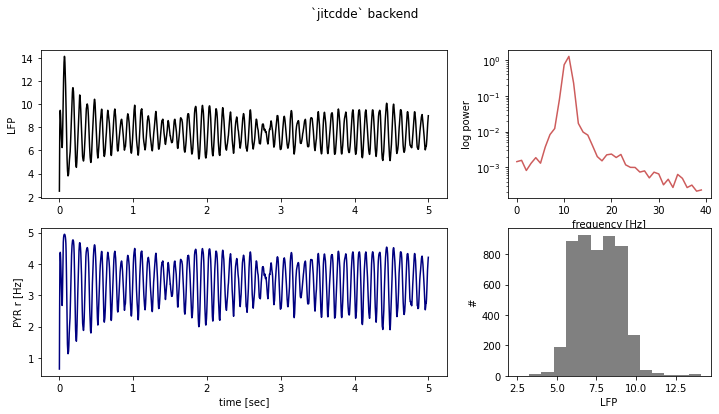

In [8]:
_, axs = plt.subplots(
    nrows=2, ncols=2, figsize=(12, 6), gridspec_kw={"width_ratios": [2, 1]}
)

axs[0, 0].plot(jr_model.t, jr_model.v_exc.T - jr_model.v_inh.T, color="k")
axs[0, 0].set_ylabel("LFP")
axs[1, 0].plot(jr_model.t, jr_model.r_mean_EXC.T * 1000, color="navy")
axs[1, 0].set_ylabel("PYR r [Hz]")
axs[1, 0].set_xlabel("time [sec]")

fr, po = getPowerSpectrum(
    (jr_model.v_exc.T - jr_model.v_inh.T).squeeze(),
    dt=jr_model.params["sampling_dt"],
    maxfr=40.0,
)
axs[0, 1].semilogy(fr, po, color="indianred")
axs[0, 1].set_xlabel("frequency [Hz]")
axs[0, 1].set_ylabel("log power")

axs[1, 1].hist(jr_model.v_exc.T - jr_model.v_inh.T, bins=15, color="gray")
axs[1, 1].set_xlabel("LFP")
axs[1, 1].set_ylabel("#")
plt.suptitle("`jitcdde` backend")

The results looks good! With the same parameters as original Jansen and Rit paper, we got the $\alpha$ activity with spectral peak around 10 Hz. Just as a proof of concept - let us try the second `MultiModel` backend.

In [9]:
# run model for 5 seconds - all in ms
jr_model.params["sampling_dt"] = 1.0
jr_model.params["dt"] = 0.1
jr_model.params["duration"] = 5000
jr_model.params["backend"] = "numba"
jr_model.run()

Text(0.5, 0.98, '`numba` backend')

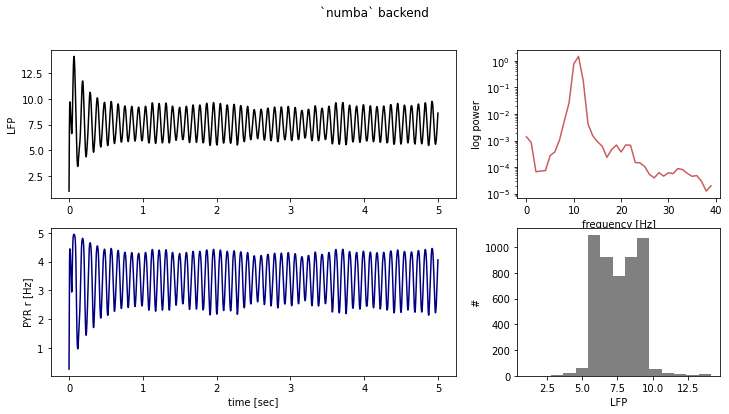

In [10]:
_, axs = plt.subplots(
    nrows=2, ncols=2, figsize=(12, 6), gridspec_kw={"width_ratios": [2, 1]}
)

axs[0, 0].plot(jr_model.t, jr_model.v_exc.T - jr_model.v_inh.T, color="k")
axs[0, 0].set_ylabel("LFP")
axs[1, 0].plot(jr_model.t, jr_model.r_mean_EXC.T * 1000, color="navy")
axs[1, 0].set_ylabel("PYR r [Hz]")
axs[1, 0].set_xlabel("time [sec]")

fr, po = getPowerSpectrum(
    (jr_model.v_exc.T - jr_model.v_inh.T).squeeze(),
    dt=jr_model.params["sampling_dt"],
    maxfr=40.0,
)
axs[0, 1].semilogy(fr, po, color="indianred")
axs[0, 1].set_xlabel("frequency [Hz]")
axs[0, 1].set_ylabel("log power")

axs[1, 1].hist(jr_model.v_exc.T - jr_model.v_inh.T, bins=15, color="gray")
axs[1, 1].set_xlabel("LFP")
axs[1, 1].set_ylabel("#")
plt.suptitle("`numba` backend")

All works as it should, we have our Jansen-Rit model! In the next step, we will showcase how the new model can be connected and coupled to other models (similar as in the first example).

## Couple Jansen-Rit to thalamic model
Here we practically copy the previous example where we coupled ALN node with a thalamic node, but instead of ALN representing a cortical column, we use our brand new Jansen-Rit model.

In [11]:
# let us start by subclassing the Network


class JansenRitThalamusMiniNetwork(Network):
    """
    Simple thalamocortical motif: 1 cortical node Jansen-Rit + 1 NMM thalamus.
    """

    # provide basic attributes as name and label
    name = "Jansen-Rit 1 node + Thalamus"
    label = "JRThlmNet"

    # define which variables are used to sync, i.e. what coupling variables our nodes need
    sync_variables = [
        # both nodes are connected via excitatory synapses
        "network_exc_exc",
        # and INH mass in thalamus also receives excitatory coupling
        "network_inh_exc",
    ]

    # lastly, we need to define what is default output of the network (this has to be the
    #     variable present in all nodes)
    # for us it is excitatory firing rates
    default_output = f"r_mean_EXC"
    # define all output vars of any interest to us - EXC and INH firing rates
    output_vars = [f"r_mean_EXC", f"r_mean_INH"]

    def __init__(self, connectivity_matrix, delay_matrix, seed=None):
        # self connections are resolved within nodes, so zeroes at the diagonal
        assert np.all(np.diag(connectivity_matrix) == 0.0)

        # init Jansen-Rit node with index 0
        jr_node = JansenRitNode(seed=seed)
        jr_node.index = 0
        # index where the state variables start - for first node it is always 0
        jr_node.idx_state_var = 0
        # set correct indices for noise input - in JR we have only one noise source
        jr_node[0].noise_input_idx = [0]

        # init thalamus node with index 1
        thalamus = ThalamicNode()
        thalamus.index = 1
        # thalamic state variables start where ALN state variables end - easy
        thalamus.idx_state_var = jr_node.num_state_variables
        # set correct indices of noise input - one per mass, after ALN noise
        # indices
        for mass in thalamus:
            mass.noise_input_idx = [jr_node.num_noise_variables + mass.index]

        # now super.__init__ network with these two nodes:
        super().__init__(
            nodes=[jr_node, thalamus],
            connectivity_matrix=connectivity_matrix,
            delay_matrix=delay_matrix,
        )

    # done! the only other thing we need to do, is to set the coupling variables
    # thalamus vs. Jansen-Rit are coupled via their firing rates and here we setup the
    # coupling matrices; the super class `Network` comes with some convenient
    # functions for this

    def _sync(self):
        """
        Set coupling variables - the ones we defined in `sync_variables`
        _sync returns a list of tuples where the first element in each tuple is the coupling "symbol"
        and the second is the actual mathematical expression
        for the ease of doing this, `Network` class contains convenience functions for this:
            - _additive_coupling
            - _diffusive_coupling
            - _no_coupling
        here we use additive coupling only
        """
        # get indices of coupling variables from all nodes
        exc_indices = [
            next(
                iter(
                    node.all_couplings(
                        mass_indices=node.excitatory_masses.tolist()
                    )
                )
            )
            for node in self
        ]
        assert len(exc_indices) == len(self)
        return (
            # basic EXC <-> EXC coupling
            # within_node_idx is a list of len 2 (because we have two nodes)
            # with indices of coupling variables within the respective state vectors
            self._additive_coupling(
                within_node_idx=exc_indices, symbol="network_exc_exc"
            )
            # EXC -> INH coupling (only to thalamus)
            + self._additive_coupling(
                within_node_idx=exc_indices,
                symbol="network_inh_exc",
                connectivity=self.connectivity,
            )
            + super()._sync()
        )

In [12]:
# lets check what we have
# in the ALN-thalamus case the matrix was [0.0, 0.15], [1.2, 0.0] - JR produces firing rates around 5Hz (5 times lower than ALN)
SC = np.array([[0.0, 0.15], [6., 0.0]])
delays = np.array([[0.0, 13.0], [13.0, 0.0]]) # thalamocortical delay = 13ms
thalamocortical = MultiModel(JansenRitThalamusMiniNetwork(connectivity_matrix=SC, delay_matrix=delays, seed=42))
# original `MultiModel` instance is always accessible as `MultiModel.model_instance`
display(thalamocortical.model_instance.describe())

{'name': 'Jansen-Rit 1 node + Thalamus',
 'num_nodes': 2,
 'num_state_variables': 24,
 'num_noise_variables': 3,
 'nodes': [{'index': 0,
   'name': 'Jansen-Rit node',
   'num_masses': 1,
   'num_num_state_variables': 7,
   'num_noise_variables': 1,
   'masses': [{'index': 0,
     'name': 'Jansen-Rit mass',
     'mass_type': None,
     'num_state_variables': 7,
     'num_noise_variables': 1,
     'state_variable_names': ['v_pyr',
      'dv_pyr',
      'v_exc',
      'dv_exc',
      'v_inh',
      'dv_inh',
      'r_mean_EXC'],
     'params': {'A': 3.25,
      'B': 22.0,
      'a': 0.1,
      'b': 0.05,
      'v0': 6.0,
      'v_max': 0.005,
      'r': 0.56,
      'C': 135.0,
      'lambda': 10.0,
      'input_0': {'type': 'UniformlyDistributedNoise',
       'low': 0.12,
       'high': 0.32,
       'n': 1,
       'seed': 42}}}]},
  {'index': 1,
   'name': 'Thalamic mass model node',
   'num_masses': 2,
   'num_num_state_variables': 17,
   'num_noise_variables': 2,
   'masses': [{'index':

In [13]:
# fix parameters for interesting regime
thalamocortical.params["*g_LK"] = 0.032 # K-leak conductance in thalamus
thalamocortical.params["*TCR*input*sigma"] = 0.005 # noise in thalamus
thalamocortical.params["*input*tau"] = 5.0 # timescale of OU process
thalamocortical.params["duration"] = 20000. # 20 seconds simulation
thalamocortical.params["sampling_dt"] = 1.0
thalamocortical.run()

/Users/nikola/.virtualenvs/neurolib/lib/python3.7/site-packages/jitcdde/_jitcdde.py:1491: UserWarning: Your input past does not begin at t=0 but at t=1.0. Values before the beginning of the past will be extrapolated. You very likely do not want this.
  warn(f"Your input past does not begin at t=0 but at t={input[0].time}. Values before the beginning of the past will be extrapolated. You very likely do not want this.")


Using default integration parameters.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:01<00:00, 18832.12it/s]


Text(0.5, 0, 'time [sec]')

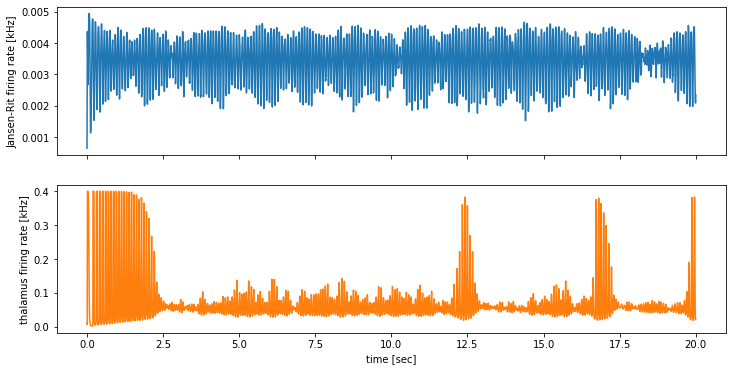

In [14]:
_, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 6))
axs[0].plot(thalamocortical.t, thalamocortical.r_mean_EXC[0, :].T)
axs[0].set_ylabel("Jansen-Rit firing rate [kHz]")
axs[1].plot(thalamocortical.t, thalamocortical.r_mean_EXC[1, :].T, color="C1")
axs[1].set_ylabel("thalamus firing rate [kHz]")
axs[1].set_xlabel("time [sec]")

So the model works, just like that! Of course, in this case we do not see anything interesting in the modelled dynamics, since we would need to proper investigation of various parameters. Consider this as a proof-of-concept, where we can very easily couple two very different population models.